# Module 09: Bagging

## Prerequisites

In [10]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *

# Modeling packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import partial_dependence
from sklearn.pipeline import Pipeline

# silence unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Ames housing data
ames = pd.read_csv("../../00-data/ML/ames.csv")

# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train[["Sale_Price"]]

## Implementation

### Basic implementation

In [12]:
# Ordinal encode our quality-based features 
ord_cols = list(X_train.filter(regex=("Qual$|QC$|Cond$")).columns)
lvs = ["Very_Poor", "Poor", "Fair", "Below_Average", "Average", "Typical", 
       "Above_Average", "Good", "Very_Good", "Excellent", "Very_Excellent"]
val = range(0, len(lvs))
lvl_map = dict(zip(lvs, val))
category_mapping = [{'col': col, 'mapping': lvl_map} for col in ord_cols]
ord_encoder = OrdinalEncoder(cols=ord_cols, mapping=category_mapping)

# one hot encode remaining nominal features
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# combine into a pre-processing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
   ("ord_encode", ord_encoder, ord_cols),
   ("one-hot", encoder, selector(dtype_include="object")),
   ]
  )

In [13]:
# create bagging estimator
dt_bag = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5)

# create modeling pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("dt_bag", dt_bag),
])

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(model_pipeline, X_train, y_train.values.ravel(), cv=kfold, scoring=loss)

np.abs(np.mean(results))

30275.10514510412

### Tuning

In [14]:
# create bagging estimator but with undefined number of bagged trees
dt_bag = BaggingRegressor(base_estimator=DecisionTreeRegressor())

# Create grid of hyperparameter values
hyper_grid = {'dt_bag__n_estimators': [5, 25, 50, 100, 200]}

# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss, n_jobs=-1)
results = grid_search.fit(X_train, y_train.values.ravel())

np.abs(results.cv_results_['mean_test_score'])

array([31238.43850008, 28113.15697283, 28083.43539906, 27881.431423  ,
       27593.35300832])

In [15]:
# Best model's cross validated RMSE
abs(results.best_score_)

27593.353008323164

In [16]:
# Best model's number of trees
n_trees = results.best_estimator_.get_params().get('dt_bag__n_estimators')
n_trees

200

## Feature interpretation

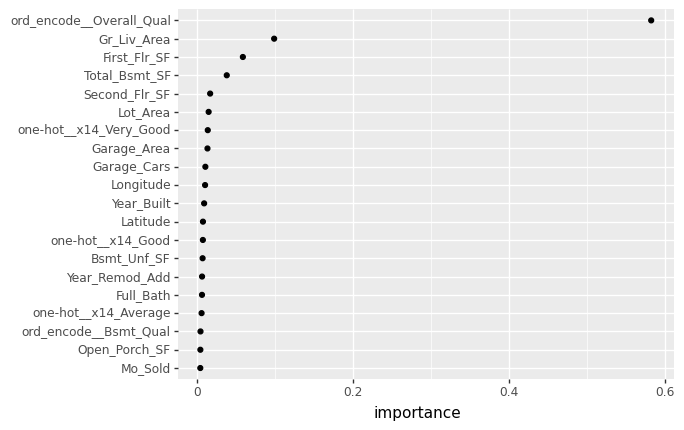

<ggplot: (363953652)>

In [18]:
# create final model object
X_encoded = preprocessor.fit_transform(X_train)
dt_bag = BaggingRegressor(
  base_estimator=DecisionTreeRegressor(), 
  n_estimators=n_trees
  )
dt_bag_fit = dt_bag.fit(X_encoded, y_train.values.ravel())

# extract feature importances
feature_importances = [tree.feature_importances_ for tree in dt_bag_fit.estimators_ ]
avg_feature_importances = np.mean(feature_importances, axis=0)
vi = pd.DataFrame({'feature': preprocessor.get_feature_names(),
                   'importance': avg_feature_importances})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

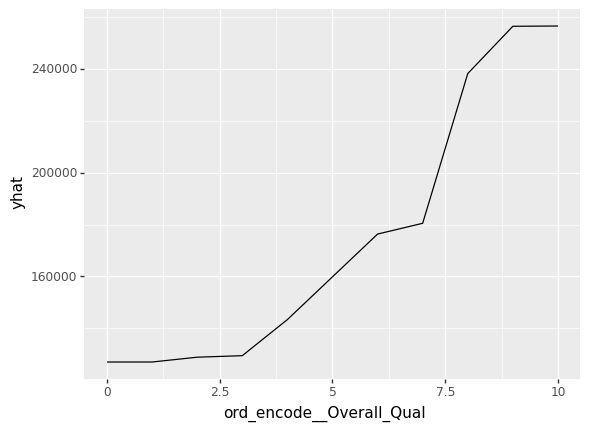

<ggplot: (363911096)>

In [19]:
X_encoded = pd.DataFrame(X_encoded, columns=preprocessor.get_feature_names())
pd_results = partial_dependence(
  dt_bag_fit, X_encoded, "ord_encode__Overall_Qual", kind='average',
  percentiles=(0, 1)) 
  
pd_output = pd.DataFrame({'ord_encode__Overall_Qual': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('ord_encode__Overall_Qual', 'yhat'))
  + geom_line())

## Exercises

Using the Boston housing data set, where the response feature is the median value of homes within a census tract (`cmedv`):

1. Apply a bagged decision tree model with all features.
2. How many trees are required before the loss function stabilizes?
3. Adjust different tuning parameters and assess how performance changes.
4. How does the model performance compare to the decision tree model applied in the previous module's exercise?
5. Which 10 features are considered most influential? Are these the same features that have been influential in previous model?
6. Create partial dependence plots for the top two most influential features. Explain the relationship between the feature and the predicted values.
7. Now perform 1-6 to the Attrition dataset, which is classification model rather than a regression model.